# Categorical factors

In [1]:
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from edward.models import Normal, Categorical, Dirichlet, Empirical

In [2]:
n = 4000
k = 5
alpha0 = 1

In [3]:
probs = np.array([0.1, 0.01, 0.3, 0.6, 0.1], dtype=np.float32)
probs /= sum(probs)
X = np.random.choice(k, n, p=probs)

In [4]:
probs

array([ 0.09009009,  0.00900901,  0.27027029,  0.54054058,  0.09009009], dtype=float32)

In [5]:
d = Dirichlet(alpha0*np.ones(k, dtype=np.float32))
c = Categorical(probs = d, sample_shape=(n))

In [6]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    print(c.sample(100).eval())

[3 1 2 2 3 1 0 2 1 3 1 1 2 1 3 2 3 0 1 2 3 1 2 3 0 3 1 1 3 3 3 3 3 2 2 1 2
 1 0 3 3 1 1 1 1 2 1 3 1 3 0 0 3 3 2 3 2 3 3 2 3 3 1 1 1 0 1 0 0 0 3 1 1 2
 3 2 1 3 3 1 2 1 2 3 1 2 3 1 0 0 0 2 0 3 1 3 0 2 2 1]


In [7]:
qalpha0 =  tf.nn.softplus(tf.Variable(tf.random_normal([k], dtype=tf.float32)))
#qalpha0 =  tf.nn.softmax(tf.Variable(tf.random_normal([k], dtype=tf.float32)))
qd = Dirichlet(qalpha0)

In [8]:
inference = ed.KLqp({d: qd}, data={c: X})
inference.initialize(n_iter=6000, n_print=100, n_samples=80, optimizer='rmsprop')

In [9]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [10]:
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(qalpha0.eval())
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

[ 0.41371745  0.52588457  1.10158348  0.45056808  0.22812267]
{'t': 1, 'loss': 11589.87}
[ 1.16433835  0.17745167  2.52761865  4.85402536  1.13200688]
{'t': 1001, 'loss': 5452.6772}
[ 1.69822574  0.33529058  3.69181204  7.01421404  1.72443068]
{'t': 2001, 'loss': 5234.3994}
[ 1.94946098  0.35135531  4.58623981  8.86412621  1.92034984]
{'t': 3001, 'loss': 5069.0029}
[  2.08396959   0.33220524   5.19601345  10.32888031   2.1298213 ]
{'t': 4001, 'loss': 5023.9204}
[  2.44611692   0.40770847   5.827353    11.68071079   2.11970949]
{'t': 5001, 'loss': 4992.3486}


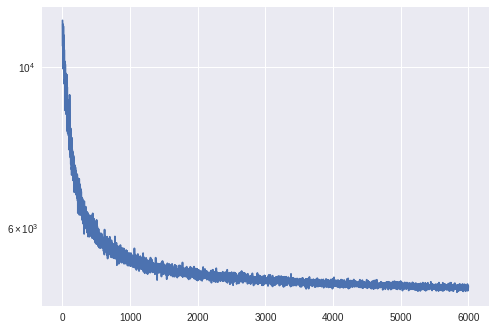

In [11]:
plt.show()

In [12]:
qd.mean().eval()

array([ 0.10386574,  0.01502858,  0.2571587 ,  0.51895648,  0.10499046], dtype=float32)

In [13]:
probs

array([ 0.09009009,  0.00900901,  0.27027029,  0.54054058,  0.09009009], dtype=float32)

In [14]:
X_sim = ed.copy(c, {d: qd})

In [15]:
X_sim_sample = X_sim.sample(n).eval()

In [16]:
probs_MLE, _ = np.histogram(X,bins=np.arange(k+1),normed=True)

In [17]:
np.dot(probs, probs)/np.linalg.norm(probs)**2

0.99999996923156298

In [18]:
np.dot(probs_MLE, probs)/(np.linalg.norm(probs)*np.linalg.norm(probs_MLE))

0.99989819680268766

In [19]:
probs_ADVI, _ = np.histogram(X_sim_sample,bins=np.arange(k+1),normed=True)

In [20]:
np.dot(probs_ADVI, probs)/(np.linalg.norm(probs)*np.linalg.norm(probs_ADVI))

0.98194196755657237